In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import pickle

from rdkit import Chem
from rdkit.Chem import Descriptors

from rogi import RoughnessIndex

from tdc.generation import MolGen
from tdc import Oracle
from tdc.single_pred import ADME, Tox

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
sns.set(style='ticks')

In [2]:
def compute_rdkit_descriptors(smi):
    m = Chem.MolFromSmiles(smi)
    descriptor_names = [desc[0] for desc in Descriptors.descList]
    descriptor_funcs = [desc[1] for desc in Descriptors.descList]
    descriptors = [desc(m) for desc in descriptor_funcs]
    return descriptors


def smiles_to_descriptors_df(smiles, descriptors=None):
    Xdict = {}
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    for desc in Descriptors.descList:
        name = desc[0]
        f = desc[1]

        if descriptors is not None and name in descriptors:
            Xdict[name] = [f(m) for m in mols]
    return pd.DataFrame(Xdict)
    
    
def apply_alpha_to_boxplot(boxplot_obj, alpha=0.5):
    for patch in boxplot_obj.artists:   
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, alpha))
        
        
def plot_scatter(ax, x, y, title='', marker='X', s=100, 
                 fit=False, fit_outline=True, fit_lw=1, fit_zorder=0,
                 color='b', edgecolor='k', linewidth=0.5, alpha_face=1, alpha_edge=1,
                 annotate=True, text_color='k', x_text=0.55, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label=''):

    if fit:
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d( coef)
        if fit_outline:
            ax.plot([min(x), max(x)], [poly1d_fn(min(x)), poly1d_fn(max(x))], linestyle='-', color='white', zorder=fit_zorder-1, linewidth=fit_lw+1)
        ax.plot([min(x), max(x)], [poly1d_fn(min(x)), poly1d_fn(max(x))], linestyle='--', color=color, zorder=fit_zorder, linewidth=fit_lw)

    # face
    ax.scatter(x, y, marker=marker, s=s, color=color, edgecolor='none', linewidth=0, alpha=alpha_face, zorder=zorder_scatter, label=label)
    # edges
    ax.scatter(x, y, marker=marker, s=s, facecolor="none", edgecolor=edgecolor, linewidth=linewidth, alpha=alpha_edge, zorder=zorder_scatter)

    ax.set_title(title)

    if annotate:
        pears = pearsonr(x, y)[0]
        _ = ax.annotate(f'$r = {pears:.2f}$', xy=(x_text, y_text), xycoords='axes fraction', ha='right', color=text_color, fontsize=fontsize,
                        zorder=10, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
        
    
colors = ['#DF9216','#d1495b','#00798c']

In [3]:
# ----------------
# Guacamol Oracles
# ----------------
# NOTE: we do not use "Sitagliptin_MPO" because it returns NaNs for some SMILES
oracle_names = ['QED', 'LogP', 'Celecoxib_Rediscovery', 'Aripiprazole_Similarity', 'Median 1', 
                'Osimertinib_MPO', 'Fexofenadine_MPO', 'Ranolazine_MPO', 'Perindopril_MPO', 'Amlodipine_MPO', 'Zaleplon_MPO',
                'Valsartan_SMARTS', 'Scaffold Hop']

# ------------------------
# TDC regression datasets
# ------------------------
adme_props = [('Caco2_Wang', None), 
              ('Lipophilicity_AstraZeneca', None), 
              ('Solubility_AqSolDB', None), 
              ('HydrationFreeEnergy_FreeSolv', None), 
              ('PPBR_AZ', None), 
              ('VDss_Lombardo', None),
              ('Half_Life_Obach', None), 
              ('Clearance_Hepatocyte_AZ', None), 
              ('Clearance_Microsome_AZ', None)]

tox_props = [('LD50_Zhu', None),
             ('herg_central', 'hERG_at_1uM'), 
             ('herg_central', 'hERG_at_10uM')]

# combine
props = []
props.extend(adme_props)
props.extend(tox_props)

# def func to get TDC dataset
def get_tdc_dataset(name, label_name):
        
    if (name, label_name) in adme_props:
        df = ADME(name=name, label_name=label_name).get_data()
    elif (name, label_name) in tox_props:
        df = Tox(name=name, label_name=label_name).get_data()
    else:
        raise ValueError(f'Cannot understand {name}, {label_name}')
        
    # subsample
    if len(df) > 10000:
        df = df.sample(n=10000, random_state=42)
    
    return df

# --------------------------------------------
# select a bunch of commonly-used descriptors
# --------------------------------------------
desc_names = ['MolWt', 'FractionCSP3', 'NumHAcceptors', 'NumHDonors', 'NOCount', 'NHOHCount',
              'NumAliphaticRings', 'NumAliphaticHeterocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 
              'NumRotatableBonds', 'TPSA', 'qed', 'MolLogP']

# -----------------------------
# Dict use to store all results
# -----------------------------
RESULTS = {}
RESULTS['ZINC'] = {}
RESULTS['TDC'] = {}
RESULTS['TILBORG'] = {}

## ZINC+GuacaMol: 10,000 molecules

In [5]:
# sample 10000 molecules at random from ZINC
data = MolGen(name='ZINC')
data_sample = data.get_data().sample(n=10000, replace=False, random_state=42)
smiles = data_sample.loc[:, 'smiles'].to_numpy()

Found local copy...
Loading...
Done!


In [6]:
# =============
# FINGERPRINTS
# =============

nums_samples = [10, 100, 1000, 2000, 5000, 10000]

RESULTS['ZINC']['FPS'] = {}
       
for name in oracle_names:
    print(f'{name}')
    RESULTS['ZINC']['FPS'][name] = {}
    oracle = Oracle(name=name)
    
    for num_samples in nums_samples:
        print(f'    {num_samples:>4}', end=' ')
        
        RESULTS['ZINC']['FPS'][name][num_samples] = []
    
        if num_samples < 10000:
            n_repeats = 10
        else:
            n_repeats = 1
        
        for n in range(n_repeats):
            print('.', end='')
            np.random.seed(n)
            smi = np.random.choice(smiles, size=num_samples, replace=False)
            Y = oracle(list(smi))
            ri = RoughnessIndex(smiles=smi, Y=Y, verbose=False)
            score, score_serr = ri.compute_index(min_dt=0.01, nboots=20)
            RESULTS['ZINC']['FPS'][name][num_samples].append((score, score_serr))
        print()

QED
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .

Found local copy...



LogP
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Celecoxib_Rediscovery
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Aripiprazole_Similarity
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Median 1
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Osimertinib_MPO
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Fexofenadine_MPO
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Ranolazine_MPO
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Perindopril_MPO
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..

In [7]:
# =============
# DESCRIPTORS
# =============

RESULTS['ZINC']['DESC'] = {}

# ----------------
# get descriptors 
# ----------------
descriptor_funcs = {desc[0]:desc[1] for desc in Descriptors.descList}
X = []
for smi in smiles:
    m = Chem.MolFromSmiles(smi)
    Xi = []
    for desc_name in desc_names:
        desc = descriptor_funcs[desc_name](m)
        Xi.append(desc)
    X.append(Xi)

X = np.array(X)
# normalize features (this involves some data leakage and slighly inflates performance, but it does not really matter here)
_X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# ----------------

       
for name in oracle_names:
    print(f'{name}')
    RESULTS['ZINC']['DESC'][name] = {}
    oracle = Oracle(name=name)
    
    for num_samples in nums_samples:
        print(f'    {num_samples:>4}', end=' ')
        
        RESULTS['ZINC']['DESC'][name][num_samples] = []
    
        if num_samples < 10000:
            n_repeats = 10
        else:
            n_repeats = 1
        
        for n in range(n_repeats):
            print('.', end='')
            np.random.seed(n)
            idx = np.random.choice(range(10000), size=num_samples, replace=False)
            Y = oracle(list(smiles[idx]))
            
            ri = RoughnessIndex(Y=Y, X=_X[idx,:], metric='euclidean', verbose=False)
            score, score_serr = ri.compute_index(min_dt=0.01, nboots=20)
            RESULTS['ZINC']['DESC'][name][num_samples].append((score, score_serr))
        print()

QED
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
LogP
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Celecoxib_Rediscovery
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Aripiprazole_Similarity
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Median 1
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Osimertinib_MPO
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Fexofenadine_MPO
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    10000 .
Ranolazine_MPO
      10 ..........
     100 ..........
    1000 ..........
    2000 ..........
    5000 ..........
    

In [8]:
# save results
with open('convergence_results.pkl', 'wb') as f:
    pickle.dump(RESULTS, f)

## Plot results

In [9]:
# load results
with open('convergence_results.pkl', 'rb') as f:
    RESULTS = pickle.load(f)

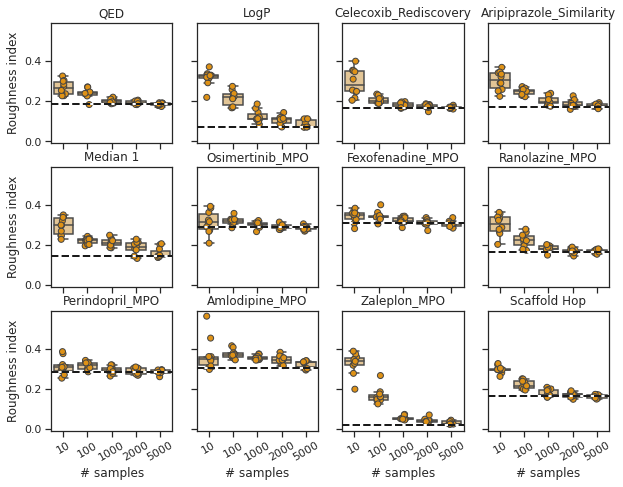

In [15]:
def results2df(RESULTS, dataset='ZINC', rep='FPS', prop='QED'):
    all_n = []
    all_scores = []
    all_sderrs = []
    for n in [10, 100, 1000, 2000, 5000]:
        data = RESULTS[dataset][rep][prop][n]
        scores = [x[0] for x in data]
        sderrs = [x[1] for x in data]
        all_scores.extend(scores)
        all_sderrs.extend(sderrs)
        all_n.extend([n] * len(scores))
    return pd.DataFrame({'N':all_n, 'rogi':all_scores, 'rogi_stderr':all_sderrs})


DATASET = 'ZINC'
REPR = 'DESC'


ncols = 4
nrows = 3
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*2.5,nrows*2.5), sharey=True, sharex=True)

# eclude Valsartan_SMARTS as it's always zero anyway, always flat, not very useful/informative
for i, name in enumerate([x for x in oracle_names if x != 'Valsartan_SMARTS']):
    
    col = i % ncols
    row = i // ncols
    ax = axes[row, col]
    
    df = results2df(RESULTS, dataset=DATASET, rep=REPR, prop=name)
    
    rogi10000 = RESULTS[DATASET][REPR][name][10000][0][0]
    ax.axhline(y=rogi10000, color='w', linestyle='-', linewidth=2, zorder=20)
    ax.axhline(y=rogi10000, color='k', linestyle='--', linewidth=2, zorder=20)
    
    box = sns.boxplot(data=df, x="N", y='rogi', ax=ax, color=colors[0], showfliers=False, zorder=5)
    strip = sns.stripplot(data=df, x='N', y="rogi", ax=ax, dodge=True, alpha=1, zorder=10, 
                          size=6, edgecolor='#444444', linewidth=1, color=colors[0])
    apply_alpha_to_boxplot(box, 0.5)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
    
for j in range(ncols):
    axes[-1,j].set_xlabel('# samples')
    #axes[-1,j].set_xticklabels(['10', '100', '1k', '2k', '5k'])
    axes[-1,j].set_xticklabels(['10', '100', '1000', '2000', '5000'], rotation=30)
    
for i in range(nrows):
    axes[i,0].set_ylabel('Roughness index')
    
fig.savefig(f'plots/convergence-{DATASET}-{REPR}.png', dpi=600, bbox_inches='tight')

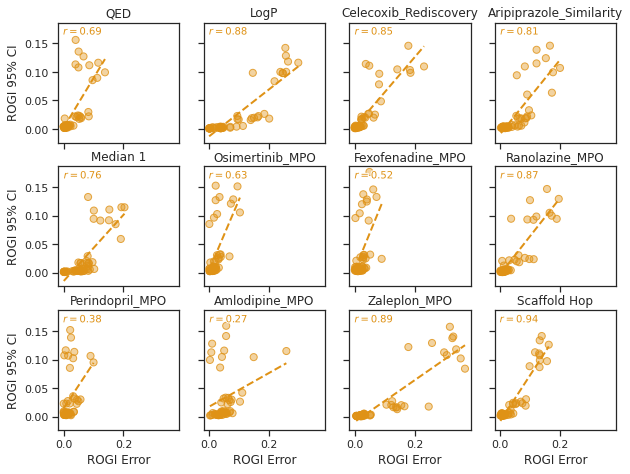

In [16]:
ncols = 4
nrows = 3
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*2.5,nrows*2.5), sharey=True, sharex=True)

# eclude Valsartan_SMARTS as it's always zero anyway, always flat, not very useful/informative
for i, name in enumerate([x for x in oracle_names if x != 'Valsartan_SMARTS']):
    
    col = i % ncols
    row = i // ncols
    ax = axes[row, col]
    
    df = results2df(RESULTS, dataset=DATASET, rep=REPR, prop=name)
    
    rogi10000 = RESULTS[DATASET][REPR][name][10000][0][0]
    
    errors = np.abs(df.loc[:, 'rogi'] - rogi10000)
    uncertainties = df.loc[:, 'rogi_stderr'] * 1.96
    
    plot_scatter(ax, errors, uncertainties, title=name, marker='o', s=50, 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.37, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
    
for j in range(ncols):
    axes[-1,j].set_xlabel('ROGI Error')
for i in range(nrows):
    axes[i,0].set_ylabel('ROGI 95% CI')

    
fig.savefig(f'plots/uncertainty-{DATASET}-{REPR}.png', dpi=600, bbox_inches='tight')